### Goal

In this notebook, we explore fitting 2D Gaussian functions to provided RFs. This is particularly useful for fitting retinal RFs and characterizing their properties. Here, we use RF data obtained from [Taylor et al. 2024](https://www.biorxiv.org/content/10.1101/2024.03.26.586771v1).

In [9]:
import os
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import torch
import matplotlib.pyplot as plt

from brainbox.rfs.gaussian import fit, query

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Load our example spatial RFs (shape: units x height x width)
gaussian_rfs = torch.load(f"data/gaussian_rfs.pt")

In [11]:
# Fit 2D Gaussian functions to each example RF
if not os.path.exists(f"data/rf_fits/gaussian.csv"):
    fit.GaussianFitter().fit_spatial(f"data/rf_fits/gaussian.csv", 
                                     gaussian_rfs, 
                                     batch_size=200, 
                                     n_spatial_iterations=4000, 
                                     spatial_lr=1e-1)

In [12]:
# Create a query object which gives us all the fit info
# Note: here the method expects strfs rather than rfs, so we include a temporal dimension
# by unsqueezeing the second dimension
fit_query = query.GaussianQuery(f"data/rf_fits/gaussian.csv", gaussian_rfs.unsqueeze(1))

# We can now query the fit data - you can specify the minimum CC for each unit's RF fit
params_df, spatial_rfs, gaussians, _ = fit_query.validate(min_cc=0.7)

INFO:gaussian:CC criteria exclusion 213
INFO:gaussian:Location criteria exclusion 37
INFO:gaussian:Envelope criteria exclusion 11


In [21]:
# The params_df gives us all the fitted 2D Gaussian paramters for each RF
params_df.head()

,amp,x0,y0,sigmax,sigmay,p,cc
1,8.282103,13.515543,10.758614,1.048307,1.218440,-0.004287,0.849122
2,-9.764000,10.629963,14.935437,1.856253,0.986586,0.095359,0.835597
5,-26.829912,5.896315,1.589474,2.114669,2.660697,0.259447,0.758640
8,47.848873,13.031333,9.164455,3.649757,2.382304,0.100958,0.817943
13,-9.274092,13.669727,10.759048,1.302809,1.106861,-0.041989,0.871228


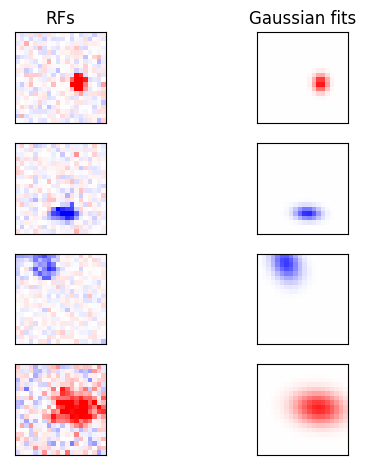

In [14]:
# The spatial_rfs and gaussians tensor return our RFs and their fits which we can plot
def plot_rf_and_fit(i, ax):
    for j in range(2):
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
    axs[i, 0].imshow(spatial_rfs.detach()[i], vmin=-1, vmax=1, cmap="bwr")
    axs[i, 1].imshow(gaussians.detach()[i], vmin=-1, vmax=1, cmap="bwr")

fig, axs = plt.subplots(4, 2)

plot_rf_and_fit(0, axs)
plot_rf_and_fit(1, axs)
plot_rf_and_fit(2, axs)
plot_rf_and_fit(3, axs)
axs[0, 0].set_title("RFs")
axs[0, 1].set_title("Gaussian fits")
fig.tight_layout()